In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%load_ext cudf.pandas
import cuml
from cuml.preprocessing.TargetEncoder import TargetEncoder
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from itertools import combinations

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv
/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv


# Load the DataFrame

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv', index_col='id')
org = pd.read_csv('/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv')

In [3]:
test['y'] = -1
print('test shape', test.shape)
test.head()

test shape (254569, 12)


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,y
id,,,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5,-1
593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1,-1
593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1,-1
593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3,-1
593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1,-1


In [4]:
org['id'] = (np.arange(len(org))+1e6).astype('int')
org = org.set_index('id')
print('Original shape', org.shape)
org.head()

Original shape (20000, 22)


,age,gender,marital_status,education_level,annual_income,monthly_income,employment_status,debt_to_income_ratio,credit_score,loan_amount,...,loan_term,installment,grade_subgrade,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies,loan_paid_back
id,,,,,,,,,,,,,,,,,,,,,
1000000,59,Male,Married,Master's,24240.19,2020.02,Employed,0.074,743,17173.72,...,36,581.88,B5,7,40833.47,24302.07,1,0,1,1
1000001,72,Female,Married,Bachelor's,20172.98,1681.08,Employed,0.219,531,22663.89,...,60,573.17,F1,5,27968.01,10803.01,1,0,3,1
1000002,49,Female,Single,High School,26181.80,2181.82,Employed,0.234,779,3631.36,...,60,76.32,B4,2,15502.25,4505.44,0,0,0,1
1000003,35,Female,Single,High School,11873.84,989.49,Employed,0.264,809,14939.23,...,36,468.07,A5,7,18157.79,5525.63,4,0,5,1
1000004,63,Other,Single,Other,25326.44,2110.54,Employed,0.260,663,16551.71,...,60,395.50,D5,1,17467.56,3593.91,2,0,2,1


In [5]:
combine = pd.concat([train, test, org], axis=0)
combine.shape

(868563, 23)

In [6]:
cat_cols = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
num_cols = test.select_dtypes(exclude='object').columns.to_list()
target = 'loan_paid_back'
base = ['annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade']

In [7]:
CATS1 = []
SIZES = {}

for c in num_cols + cat_cols:
    n = c
    if c in num_cols: 
        n = f"{c}2"
        CATS1.append(n)
        
    combine[n],_ = combine[c].factorize()
    SIZES[n] = combine[n].max()+1

    combine[c] = combine[c].astype('int32')
    combine[n] = combine[n].astype('int32')

print("New CATS:", CATS1)
print("Cardinality of all CATS:", SIZES)

New CATS: ['annual_income2', 'debt_to_income_ratio2', 'credit_score2', 'loan_amount2', 'interest_rate2', 'y2']
Cardinality of all CATS: {'annual_income2': 152960, 'debt_to_income_ratio2': 572, 'credit_score2': 406, 'loan_amount2': 139138, 'interest_rate2': 1498, 'y2': 1, 'gender': 3, 'marital_status': 4, 'education_level': 5, 'employment_status': 5, 'loan_purpose': 8, 'grade_subgrade': 30}


In [8]:
pairs = combinations(cat_cols + CATS1, 2)
new_cols = {}
CATS2 = []

for c1, c2 in pairs:
    name = "_".join(sorted((c1, c2)))
    new_cols[name] = combine[c1] * SIZES[c2] + combine[c2]
    CATS2.append(name)
if new_cols:
    new_df = pd.DataFrame(new_cols)         
    combine = pd.concat([combine, new_df], axis=1) 

print(f"Created {len(CATS2)} new CAT columns")

Created 66 new CAT columns


In [9]:
train.columns

Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'gender', 'marital_status', 'education_level',
       'employment_status', 'loan_purpose', 'grade_subgrade',
       'loan_paid_back'],
      dtype='object')

In [10]:
CE = []
CC = cat_cols + CATS1+ CATS2

print(f"Processing {len(CC)} columns... ",end="")
for i,c in enumerate(CC):
    if i%10==0: print(f"{i}, ",end="")
    tmp = combine.groupby(c).y.count()
    tmp = tmp.astype('int32')
    tmp.name = f"CE_{c}"
    CE.append( f"CE_{c}" )
    combine = combine.merge(tmp, on=c, how='left')
print()

Processing 78 columns... 0, 10, 20, 30, 40, 50, 60, 70, 


In [11]:
train = combine.iloc[:len(train)]
test = combine.iloc[len(train):len(train)+len(test)]
org = combine.iloc[-len(org):]
del combine
print("Train shape", train.shape,"Test shape", test.shape,"Original shape", org.shape )

Train shape (593994, 173) Test shape (254569, 173) Original shape (20000, 173)


# Feature engineering

In [12]:
def fe(df):

    df['income_loan_ratio'] = df['annual_income'] / (df['loan_amount'] + 1)
    df['credit_int'] = df['credit_score'] * df['interest_rate'] # using domain knowledge
    df['monthly_payment'] = df['loan_amount'] * (1 + df['interest_rate']/100) / 12
    df['loan_to_income'] = df['loan_amount'] / (df['annual_income'] + 1)    

    df['credit_sqrt'] = np.sqrt(df['credit_score'])
    df['income_sqrt'] = np.sqrt(df['annual_income'])
    df['int_sqrt'] = np.sqrt(df['interest_rate'])

    df['default_risk'] = (df['debt_to_income_ratio'] * 0.40 + 
                          (850 - df['credit_score']) / 850 * 0.35 + 
                          df['interest_rate'] / 100 * 0.25)
    
    df['high_employment_status'] = df['employment_status'].isin(['retired', 'employed', 'self-employed']).astype(int)
    df['low_employment_status'] = df['employment_status'].isin(['retired', 'employed', 'student']).astype(int)

    df['is_unemployed'] = (df['employment_status'] == 'unemployed').astype(int)
    df['interest_unemployed'] = df['interest_rate'] * df['is_unemployed']
    df['loan_unemployed'] = df['loan_amount'] * df['is_unemployed']

    return df

train = fe(train)
test = fe(test)
org = fe(org)


fe = ['income_loan_ratio', 'default_risk','income_sqrt', 'int_sqrt', 'credit_int', 'loan_to_income', 'credit_sqrt', 'monthly_payment',
     'high_employment_status', 'low_employment_status', 'is_unemployed', 'interest_unemployed', 'loan_unemployed']

In [13]:
quartiles = []
for col in num_cols:
    for q in [5, 10, 15]:
        n = f'quantile_{q}_{col}'
        train[n] = pd.qcut(train[col], q=q, labels=False, retbins=False, duplicates='drop')
        test[n] = pd.qcut(test[col], q=q, labels=False, retbins=False, duplicates='drop')
        org[n] = pd.qcut(org[col], q=q, labels=False, retbins=False, duplicates='drop')
        quartiles.append(n)

In [14]:
bins = []
for k in range(0, 1): 
    for col in ['annual_income', 'loan_amount']:
        n = f'round_{k}_{col}'
        train[n] = train[col].round(k)
        test[n] = test[col].round(k)
        org[n] = org[col].round(k)
        bins.append(n)

In [15]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,...,quantile_10_loan_amount,quantile_15_loan_amount,quantile_5_interest_rate,quantile_10_interest_rate,quantile_15_interest_rate,quantile_5_y,quantile_10_y,quantile_15_y,round_0_annual_income,round_0_loan_amount
0,29367,0,736,2528,13,0,0,0,0,0,...,0,0,3,4,4,NaN,NaN,NaN,29367,2528
1,22108,0,636,4593,12,1,1,1,1,1,...,0,1,2,3,3,NaN,NaN,NaN,22108,4593
2,49566,0,694,17005,9,1,0,0,1,1,...,6,9,0,0,0,NaN,NaN,NaN,49566,17005
3,46858,0,533,4682,16,0,0,0,1,1,...,0,1,4,6,7,NaN,NaN,NaN,46858,4682
4,25496,0,665,12184,10,1,1,0,1,0,...,3,5,0,1,1,NaN,NaN,NaN,25496,12184


In [16]:
train.dtypes

annual_income              int32
debt_to_income_ratio       int32
credit_score               int32
loan_amount                int32
interest_rate              int32
                          ...   
quantile_5_y             float64
quantile_10_y            float64
quantile_15_y            float64
round_0_annual_income      int32
round_0_loan_amount        int32
Length: 206, dtype: object

In [17]:
features = num_cols + cat_cols + CATS1 + quartiles + bins + CATS2 + CE + fe
print(len(features))

195


In [18]:
n_folds = 8

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [19]:
params = {
    'learning_rate': 0.00953204082266179, 
    'max_depth': 2, 
    "eval_metric": "auc",
    'alpha': 2.2, 
    'lambda': 5.0, 
    'subsample': 0.9591937035771712, 
    'colsample_bytree': 0.8894271062498997, 
    'min_child_weight': 1,
    "max_leaves": 36,
    'device': 'cuda',
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'random_state': 42,
    "grow_policy": "lossguide",
    'scale_pos_weight': 0.78,
}

In [20]:
oof_xgb = np.zeros(len(train))
test_xgb = np.zeros(len(test))

In [21]:
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        #dt = cudf.DataFrame(self.df.iloc[a:b])
        dt = self.df.iloc[a:b]
        input_data(data=dt[self.features], label=dt[self.target]) 
        self.it += 1
        return 1

In [22]:
fold_scores = []

for fold, (train_index, valid_index) in enumerate(kf.split(train), 1):
    print(f"\n🚀 Training Fold {fold} on GPU...")
    X_train = train.iloc[train_index][features + [target]].copy()
    X_org = org[features + [target]]
    X_train = pd.concat([X_train, X_org], axis=0, ignore_index=True)
    
    X_valid = train.iloc[valid_index][features].copy()
    y_valid = train.iloc[valid_index][target]
    X_test = test[features].copy()

    cc = CATS1 + CATS2

    for c in cc:
        TE = TargetEncoder(n_folds=10, smooth=5, split_method='random', stat='mean')
        X_train[c] = TE.fit_transform(X_train[c], X_train[target]).astype('float32')
        X_valid[c] = TE.transform(X_valid[c]).astype('float32')
        X_test[c] = TE.transform(X_test[c]).astype('float32')

    for c in cat_cols:
        X_train[c] = X_train[c].astype('category')
        X_valid[c] = X_valid[c].astype('category')
        X_test[c] = X_test[c].astype('category')
        
    X_train = IterLoadForDMatrix(X_train, features, target)
    dtrain = xgb.QuantileDMatrix(X_train, enable_categorical=True, max_bin=256)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, enable_categorical=True)

    model = xgb.train(params=params,dtrain=dtrain, num_boost_round=12500, evals=[(dtrain, "train"), (dvalid, "valid")],
                      early_stopping_rounds=300, verbose_eval=1000)
    
    oof_xgb[valid_index] = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    test_xgb += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) / n_folds
    
    fold_auc = roc_auc_score(y_valid, oof_xgb[valid_index])
    fold_scores.append(fold_auc)
    print(f"Fold {fold} AUC: {fold_auc:.5f}")


🚀 Training Fold 1 on GPU...
[0]	train-auc:0.87340	valid-auc:0.87857
[1000]	train-auc:0.92264	valid-auc:0.92529
[2000]	train-auc:0.92425	valid-auc:0.92640
[3000]	train-auc:0.92511	valid-auc:0.92685
[4000]	train-auc:0.92571	valid-auc:0.92706
[5000]	train-auc:0.92615	valid-auc:0.92719
[6000]	train-auc:0.92652	valid-auc:0.92728
[7000]	train-auc:0.92684	valid-auc:0.92732
[8000]	train-auc:0.92713	valid-auc:0.92735
[9000]	train-auc:0.92741	valid-auc:0.92738
[10000]	train-auc:0.92768	valid-auc:0.92741
[10599]	train-auc:0.92782	valid-auc:0.92741
Fold 1 AUC: 0.92741

🚀 Training Fold 2 on GPU...
[0]	train-auc:0.86185	valid-auc:0.86316
[1000]	train-auc:0.92276	valid-auc:0.92424
[2000]	train-auc:0.92440	valid-auc:0.92540
[3000]	train-auc:0.92523	valid-auc:0.92591
[4000]	train-auc:0.92582	valid-auc:0.92622
[5000]	train-auc:0.92625	valid-auc:0.92636
[6000]	train-auc:0.92661	valid-auc:0.92643
[7000]	train-auc:0.92693	valid-auc:0.92646
[7627]	train-auc:0.92711	valid-auc:0.92647
Fold 2 AUC: 0.92647

🚀 

In [23]:
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

overall_auc = roc_auc_score(train[target], oof_xgb)

print(f"\nFold Scores:")
for i, score in enumerate(fold_scores, 1):
    print(f"  Fold {i}: {score:.5f}")

print(f"\nOverall OOF AUC: {overall_auc:.5f}")
print(f"Mean Fold AUC:  {np.mean(fold_scores):.5f}")
print(f"Std Fold AUC:   {np.std(fold_scores):.5f}")


CROSS-VALIDATION RESULTS

Fold Scores:
  Fold 1: 0.92741
  Fold 2: 0.92647
  Fold 3: 0.92735
  Fold 4: 0.92623
  Fold 5: 0.92579
  Fold 6: 0.92431
  Fold 7: 0.92537
  Fold 8: 0.92737

Overall OOF AUC: 0.92628
Mean Fold AUC:  0.92629
Std Fold AUC:   0.00104


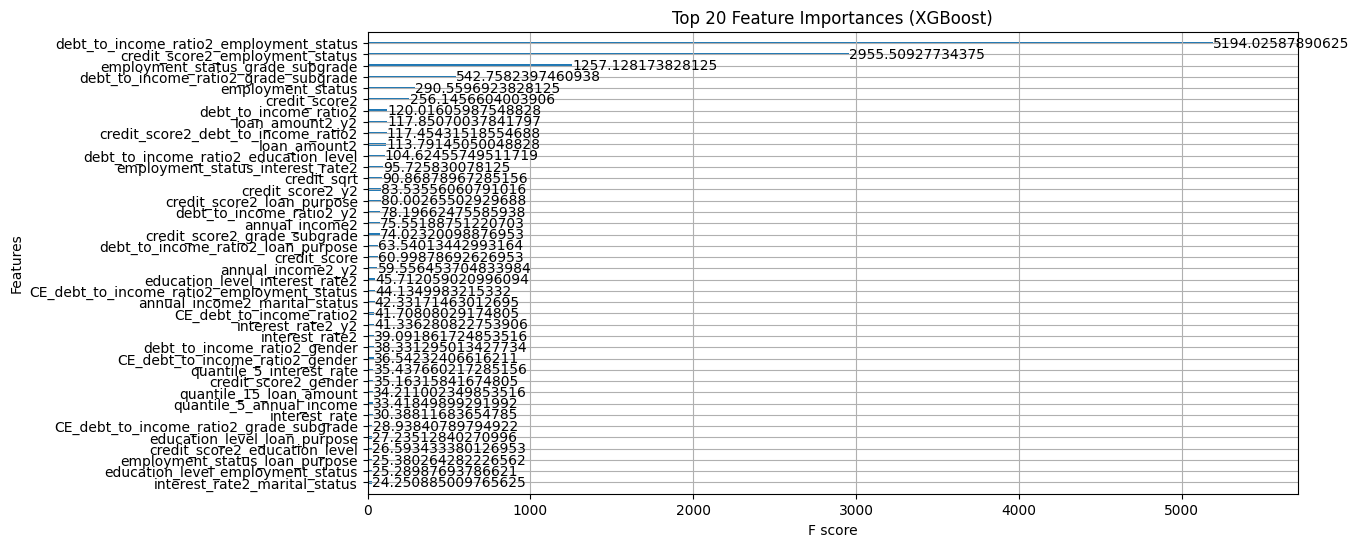

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
xgb.plot_importance(model, max_num_features=40, importance_type='gain',ax=ax)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()


In [25]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')
sub['loan_paid_back'] = test_xgb
sub.to_csv('submission.csv', index=False)
sub.head()

,id,loan_paid_back
0,593994,0.940667
1,593995,0.961562
2,593996,0.481090
3,593997,0.877354
4,593998,0.959119
